# DIVE INTO CODE COURSE
## Introductory Machine Learning Class assignment Learning Credit Information
### Doan Anh Tien - 1852789 - tien.doan.g0pr0@hcmut.edu.vn

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno as msno

## \[Problem 1] Confirmation of competition contents

### What to learn and what to predict?
From the information provided on Kaggle, each applicants will assign with a unique SK_ID_CURR (we can view it as their ID). The competition require us to learn the data from csv files, for example: the features from the main training and testing data, the feature concerning client's previous credits from another financial institutions, or the payment history for the previous loans at Home Credit, ... 

All of these explanatory variables will affect the final reponse variable TARGET that indicating the type of applicants (0 for the loan was repaid, and 1 for the loan was not repaid). And our goal is to predict the probability for each ID of applicants (submissions are evaluated on area under the ROC curve).

### What kind of file to create and submit to Kaggle?
The submission file is in the format of csv file. It should have two columns represent for SK_ID_CURR and TARGET (probability), and 345 rows (excluding the header).

### What kind of index value will be used to evaluate the submissions?
The TARGET column will be evaluated since they are the predicted probabilities.

## \[Problem 2] Learning and verification
## Pre-processing
### 1. Get in touch with the data

In [2]:
df = pd.read_csv('home_credit/application_train.csv')

# Check the number of columns and rows of this dataset
print("application_train dataset -- rows: {}, columns: {}".format(df.shape[0], df.shape[1]))

application_train dataset -- rows: 307511, columns: 122


In [3]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### 2. Check mising values

In [4]:
# Check missing values
def check_missing(df):
    # Create a hash dictionary contain missing ratio of each feature
    miss_dict = {}
    for columns in df:
        count = df[columns].isna().sum()
        ratio = count/len(df[columns])
        datatype = df[columns].dtype
        miss_dict[columns] = [count, ratio, datatype]
    
    return miss_dict

In [5]:
miss_ratio = pd.DataFrame(check_missing(df), ['Total', 'Ratio', 'Type']).T
print("Missing ratio table")
miss_ratio

Missing ratio table


,Total,Ratio,Type
SK_ID_CURR,0,0,int64
TARGET,0,0,int64
NAME_CONTRACT_TYPE,0,0,object
CODE_GENDER,0,0,object
FLAG_OWN_CAR,0,0,object
...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,41519,0.135016,float64
AMT_REQ_CREDIT_BUREAU_WEEK,41519,0.135016,float64
AMT_REQ_CREDIT_BUREAU_MON,41519,0.135016,float64
AMT_REQ_CREDIT_BUREAU_QRT,41519,0.135016,float64


### 3. Displaying feature having missing ratio > 0

In [6]:
miss_feature = miss_ratio[miss_ratio.Ratio > 0]
print("Total feature missing values: {}".format(len(miss_feature)))
miss_feature

Total feature missing values: 67


,Total,Ratio,Type
AMT_ANNUITY,12,3.9023e-05,float64
AMT_GOODS_PRICE,278,0.000904033,float64
NAME_TYPE_SUITE,1292,0.00420148,object
OWN_CAR_AGE,202929,0.659908,float64
OCCUPATION_TYPE,96391,0.313455,object
...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,41519,0.135016,float64
AMT_REQ_CREDIT_BUREAU_WEEK,41519,0.135016,float64
AMT_REQ_CREDIT_BUREAU_MON,41519,0.135016,float64
AMT_REQ_CREDIT_BUREAU_QRT,41519,0.135016,float64


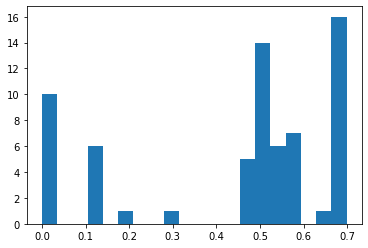

In [7]:
plt.hist(miss_feature['Ratio'], bins=20)
plt.show()

### 4. Testing out the imputer to fill the missing values

In [8]:
# Take the AMT_ANNUITY as an example
print("Number of missing value: {}".format(df['AMT_ANNUITY'].isna().sum()))

Number of missing value: 12


In [9]:
from sklearn.impute import SimpleImputer
import numpy as np
imr = SimpleImputer(missing_values=np.NaN, strategy='mean')
imr = imr.fit(df[['AMT_ANNUITY']])
df['AMT_ANNUITY'] = imr.transform(df[['AMT_ANNUITY']]).ravel()

In [10]:
print("Number of missing value: {}".format(df['AMT_ANNUITY'].isna().sum()))

Number of missing value: 0


## Joining train and test dataset for assesing

## 1. Join the dataset

In [11]:
df_train = pd.read_csv('home_credit/application_train.csv')
df_test = pd.read_csv('home_credit/application_test.csv')

In [12]:
print("The shape of our full dataset: ({}, {})".format(df_train.shape, df_test.shape))

The shape of our full dataset: ((307511, 122), (48744, 121))


In [13]:
target = df_train['TARGET'] 
df_train = df_train.drop('TARGET', axis=1)

In [14]:
df_train['training_dataset'] = True # distinguish the train and test dataset when join them together
df_test['training_dataset'] = False
test_index = df_test['SK_ID_CURR']

In [15]:
df_total = pd.concat([df_train, df_test]) #concatenate both dataframes
df_total = df_total.drop('SK_ID_CURR', axis=1) #drop SK_ID_CURR variable
print("The shape of our full dataset: {}".format(df_total.shape))

The shape of our full dataset: (356255, 121)


### 2. Convert the categorical features into numerical (encoding)

In [16]:
from sklearn.preprocessing import LabelEncoder
# Create a label encoder object
label_en = LabelEncoder()

In [17]:
df_total.dtypes.value_counts()

float64    65
int64      39
object     16
bool        1
dtype: int64

The LabelEncoder function allow us to encode the categorical feature between 0 or 1, so we only get the column with at most 2 labels.

In [18]:
label_en_count = 0 # count the number of categorical features that can be converted
for columns in df_total.columns[1:]: # We do not need the NAME_CONTRACT_TYPE columns since it the same with TARGET variables
    if df_total[columns].dtype == 'object':
        if len(list(df_total[columns].unique())) <= 2:
            label_en.fit(df_total[columns])
            df_total[columns] = label_en.transform(df_total[columns])
            label_en_count += 1
            print("{} have been modified".format(columns))

print('{} columns have been encoded.'.format(label_en_count))

FLAG_OWN_CAR have been modified
FLAG_OWN_REALTY have been modified
2 columns have been encoded.


And those columns with more than 3 features (the columns that were not encoded) will be called dummy data

In [19]:
df_total = pd.get_dummies(df_total)

In [20]:
print("The shape of full ENCODED dataset: {}".format(df_total.shape))

The shape of full ENCODED dataset: (356255, 243)


In [21]:
df_total.dtypes.value_counts()

uint8      136
float64     65
int64       39
int32        2
bool         1
dtype: int64

In [22]:
df_total.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,0,0,0,0,0,1,0,1,0
1,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,1,0,0,0,0,0,0,1,0
2,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0,0,0,0,0,0,0,0,0,0


As a result, the number of features have increased from 121 to 243 and all features will have the same format so we can apply such algorithms like Linear Regression or Random Forest Classifier properly.

### 3. Fill all missing values of dataset

In [23]:
print("Total missing value BEFORE imputing: {}".format(df_total.isna().sum().sum()))

Total missing value BEFORE imputing: 9673479


In [24]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

def fill_missing_value(df):
    new_df = df
    imr = SimpleImputer(missing_values=np.NaN, strategy='median')
    #scaler = StandardScaler()
    #scaler = MinMaxScaler(feature_range = (0, 1))
    for columns in new_df.columns[2:]:
        #if is_numeric_dtype(new_df[columns]):
        imr_all = imr.fit(new_df[[columns]])
        new_df[columns] = imr_all.transform(new_df[[columns]]).ravel()
        #scaler_all = scaler.fit(new_df[[columns]])
        #new_df[columns] = scaler_all.transform(new_df[[columns]]).ravel()

    return new_df

In [25]:
df_total = fill_missing_value(df_total)

In [26]:
print("Total missing value AFTER imputing: {}".format(df_total.isna().sum().sum()))

Total missing value AFTER imputing: 0


In [27]:
miss_ratio_full = pd.DataFrame(check_missing(df_total), ['Total', 'Ratio', 'Type']).T
print("Missing ratio table after imputing and encoding")
miss_ratio_full

Missing ratio table after imputing and encoding


,Total,Ratio,Type
FLAG_OWN_CAR,0,0,int32
FLAG_OWN_REALTY,0,0,int32
CNT_CHILDREN,0,0,float64
AMT_INCOME_TOTAL,0,0,float64
AMT_CREDIT,0,0,float64
...,...,...,...
WALLSMATERIAL_MODE_Panel,0,0,float64
"WALLSMATERIAL_MODE_Stone, brick",0,0,float64
WALLSMATERIAL_MODE_Wooden,0,0,float64
EMERGENCYSTATE_MODE_No,0,0,float64


In [28]:
print("Total missing value: {}".format(int(miss_ratio_full[miss_ratio_full.Total > 0].sum().sum())))

Total missing value: 0


After using imputer, the number of missing values has dramatically decreased by more than 10 times compared to its raw state. The stategy for imputer is using the median value - calculated from the exist data - to fill up the blanks. And the scaler is used to normalize the range of the features to scale them between values 0 and 1.

At this point, our preprocessing step is more easily to adapt and optimize to the training and learning stage.

## \[Problem 3] Estimation on test data
### 1. Dataset Preparation

In [29]:
df_train = df_total[df_total['training_dataset']==True]
df_train = df_train.drop('training_dataset', axis=1)
df_test = df_total[df_total['training_dataset']==False]
df_test = df_test.drop('training_dataset', axis=1)

In [30]:
print('Size of Train Dataset:', df_train.shape)
print('Size of Test Dataset:', df_test.shape)
print('Size of target:', target.shape)

Size of Train Dataset: (307511, 242)
Size of Test Dataset: (48744, 242)
Size of target: (307511,)


### 2. Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

log_reg_model = LogisticRegression(random_state = 40)

log_reg_model.fit(df_train, target)
log_reg_pred = log_reg_model.predict(df_test)

C:\Users\ferbd\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
output_df = pd.DataFrame({"SK_ID_CURR": test_index,
                          "TARGET": log_reg_pred})
output_df.to_csv("atien228_logreg_submission.csv", index=False)

In [34]:
from IPython.display import Image

After submitting to Kaggle, I have been evaluated, and get a ROC AUC score of 0.50389. In summary, the Linear Regression method worked not so well for our dataset.

![Kaggle score on Linear Regression model](learning_credit_figure/log_reg.png)

## \[Problem 4] Feature engineering
The Linear Regression predict whether the TARGET variable is 0 or 1 in our previous run, thus our submission contains 100% of 0 values, leading to the very low score. Moreover, the result does not show any improvement because they are all 0 and Linear Regression is not a good way to apply into binary prediction.

From the last assignment of Predicing House Price, we have tried to implement the model of Linear Regression, Randon Forest Classifier, or Decision Tree Regression, and it turned out that Random Forest Classifier are the most optimized and well-performed method. Using the Random Forest Classifier model may give us the oppoturnity to improve the accuracy of this problem.

### 1. Random Forest Classifier (with Feature Selection)

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

ran_forest_model = Pipeline([('scale', StandardScaler()),
                            ('feature_selection', SelectFromModel(LinearSVC())),
                            ('classification', RandomForestClassifier())
                            ])
ran_forest_model.fit(df_train, target)
ran_forest_pred = ran_forest_model.predict_proba(df_test)[:, 1]

In [37]:
output_df = pd.DataFrame({"SK_ID_CURR": test_index,
                          "TARGET": ran_forest_pred})
output_df.to_csv("atien228_ranforest_submission.csv", index=False)

After submitting to Kaggle, I have been evaluated, and get a ROC AUC score of 0.68297. The Random Forest Classifier method wprked better on our dataset this tame.

![Kaggle score on Random Forest Classifier model](learning_credit_figure/ran_forest.png)

### 2. Tuned Random Forest Classifier (with Feature Selection)

In [47]:
tuned_ran_forest_model = Pipeline([('scale', StandardScaler()),
                                   ('feature_selection', SelectFromModel(LinearSVC())),
                                   ('classification', RandomForestClassifier(n_estimators=250, 
                                                                             min_samples_split=10, 
                                                                             min_samples_leaf=5, 
                                                                             n_jobs=-1, 
                                                                             random_state=40,
                                                                             verbose=1))
                                                                            ])

In [50]:
tuned_ran_forest_model.fit(df_train, target)
tuned_ran_forest_pred = tuned_ran_forest_model.predict_proba(df_test)[:, 1]

C:\Users\ferbd\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.9s finished


In [51]:
output_df = pd.DataFrame({"SK_ID_CURR": test_index,
                          "TARGET": tuned_ran_forest_pred})
output_df.to_csv("atien228_tuned_ranforest_submission.csv", index=False)

After submitting to Kaggle, I have been evaluated, and get a ROC AUC score of 0.70399. This time the model worked better when its hyperparameters are tuned.

![Kaggle score on Random Forest Classifier model](learning_credit_figure/tuned_ran_forest.png)

### 3. Linear Discriminant Analysis (with Feature Selection)
A classifier with a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule.

The model fits a Gaussian density to each class, assuming that all classes share the same covariance matrix.

In [53]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_model = Pipeline([('scale', StandardScaler()),
                     ('feature_selection', SelectFromModel(LinearSVC())),
                     ('classification', LinearDiscriminantAnalysis())
                     ])

In [54]:
lda_model.fit(df_train, target)
lda_pred = lda_model.predict_proba(df_test)[:, 1]

C:\Users\ferbd\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [56]:
output_df = pd.DataFrame({"SK_ID_CURR": test_index,
                          "TARGET": lda_pred})
output_df.to_csv("atien228_lda_submission.csv", index=False)

After submitting to Kaggle, I have been evaluated, and get a ROC AUC score of 0.72394. This is the best scored I've made so far.

![Kaggle score on Random Forest Classifier model](learning_credit_figure/lda.png)

### 4. Decision Tree Regressor

In [33]:
from sklearn.tree import DecisionTreeClassifier
dec_tree_model = Pipeline([('scale', StandardScaler()),
                     ('feature_selection', SelectFromModel(LinearSVC())),
                     ('classification', DecisionTreeClassifier(random_state=40))
                     ])

In [34]:
dec_tree_model.fit(df_train, target)
dec_tree_pred = dec_tree_model.predict_proba(df_test)[:, 1]

C:\Users\ferbd\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [35]:
output_df = pd.DataFrame({"SK_ID_CURR": test_index,
                          "TARGET": dec_tree_pred})
output_df.to_csv("atien228_dec_tree_submission.csv", index=False)

After submitting to Kaggle, I have been evaluated, and get a ROC AUC score of 0.53093. This Decision Tree Classifier worked a little better than Linear Regression in term of predicting probatility, whereas it run time consumer way longer than we expected.

![Kaggle score on Random Forest Classifier model](learning_credit_figure/dec_tree.png)

## Results
Here is the table that compare the benchmark of all methods that we have implemented in this project

In [36]:
scores = {'1. Logistic Regression': [0.50389], 
          '2. Default Random Forest': [0.68297], 
          '3. Tuned Random Forest': [0.70399], 
          '4. Linear Discriminate Analysis': [0.72394],
          '5. Decision Tree': [0.53093]}
metric = ['ROC AUC Score']
df_results = pd.DataFrame(data=scores, index = metric).T
df_results

,ROC AUC Score
1. Logistic Regression,0.50389
2. Default Random Forest,0.68297
3. Tuned Random Forest,0.70399
4. Linear Discriminate Analysis,0.72394
5. Decision Tree,0.53093


We conclude that Linear Discriminate Analysis algorithms worked the best and gave us a ROC AUC score of 0.72394